# 합성곱 신경망을 사용한 이미지 분류

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

#수업시간에 배운 CNN을 이용하여 이미지를 분류해 보자!!!


데이터 셋 정보: http://yann.lecun.com/exdb/mnist/

## MNIST 데이터 셋 읽어오기

In [35]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt



(train_input, train_target), (test_input, test_target) = \
    keras.datasets.mnist.load_data()


##로드한 데이터의 shape을 확인하시오 (샘플 수: 60000, 28 x 28).
##데이터 셋의 클래스 수를 확인하시오 (numpy unique() 활용 - 2일차 교육 MNIST 실습의 데이터 준비 슬라이드 참고)

In [36]:
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

import numpy as np

print(np.unique(train_target, return_counts=True))

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


## 이미지에 깊이 1을 추가하고, 픽셀값을 0~1값으로 정규화하시오


In [37]:
#이미지 정규화 (전체 픽셀을 각각 255.0로 나눔)
train_scaled = train_input.reshape(-1,28,28,1) / 255.0

##데이터 세트를 훈련데이터 (80%)와 검증세트로 분리하시오

In [38]:
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

#분류가 잘 되었는지 확인하시오 (훈련 세트 = 48000, 검증세트 = 12000)

In [39]:
#shape를 출력
print(train_scaled.shape, train_target.shape)
print(val_scaled.shape, val_target.shape)

(48000, 28, 28, 1) (48000,)
(12000, 28, 28, 1) (12000,)


## matplotlib의 imshow() 메소드를 사용하여 정규화된 훈련세트의 5번째 인덱스의 이미지를 color bar와 함께 출력하시오. 

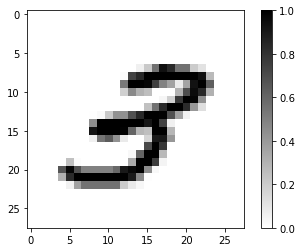

In [40]:
import matplotlib.pyplot as plt
plt.imshow(train_scaled[5].reshape(28,28), cmap="gray_r") #변수명은 변경 가능
plt.colorbar()
plt.show()

## 합성곱 신경망 만들기

In [41]:
model = keras.Sequential()

##첫번째 합성곱 층을 생성후 모델에 추가하시오.
필터 수: 32개\
필터 (커널) 사이즈: 3 x 3 x 1\
활성화 함수: ReLU\
패딩: same padding\
stride: 1\
input_shape는 데이터 특성에 맞게 지정

In [42]:
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28,28,1)))

## 2x2 최대 풀링 (max pooling) 층을 추가하시오

In [43]:
model.add(keras.layers.MaxPooling2D(2,2))

##두번째 합성곱 층을 생성 후 모델에 추가하시오
필터 수: 64개\
필터 (커널) 사이즈: 3 x 3 x 32\
활성화 함수: ReLU\
패딩: same padding\
stride: 1

In [44]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))

## 2x2 최대 풀링 (max pooling) 층을 추가하시오.
stride: 2

In [48]:
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

## Flatten 층을 추가하고, 출력을 위한 Dense 층 두개를 추가하시오.
## 첫번째 Dense 층 이후에 Dropout 층을 추가하시오 (Dropout율: 30%) 
첫번째 Dense 층의 뉴런 갯수: 100개\
첫번째 Dense 층의 활성화 함수: ReLU\
두번째 Dense 층의 뉴런 갯수: 데이터 특성에 맞게 설정\
두번째 Dense 층의 활성화 함수: Softmax


In [49]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation='softmax'))

##model.summary()를 사용하여 모델이 잘 구성되었는지 확인

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               313700    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

##utils.plot_model()을 사용하여 모델이 잘 구성되었는지 확인

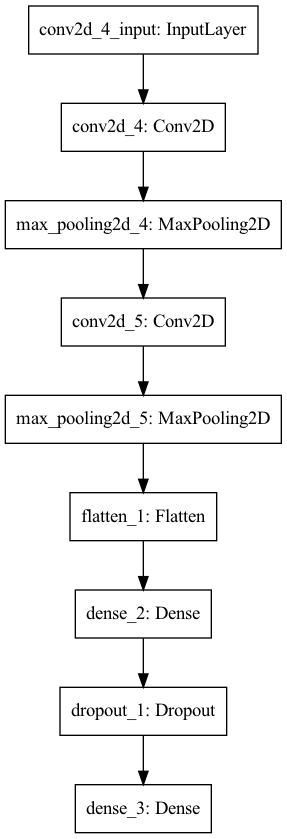

In [64]:
keras.utils.plot_model(model,to_file='mnist_model.png')

## 모델 컴파일과 훈련
optimizer: adam\
손실함수: 다중분류를 위한 함수로 지정\
accuracy 메트릭 추가

In [52]:
#accuracy는 매개변수를 통해 별도 추가
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## ModelCheckPoint 콜백 및 Early_stopping 콜백 사용을 사용하여 최적의 모델을 찾고 저장하시오.
##에포크는 적당히 큰 값으로 설정 (예: 30)
## patience: 2

In [53]:
##modelCheckPoint 콜백과 Early_stopping 콜백은 리스트로 동시에 전달 가능
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-mnist-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=30, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 182s 4ms/sample - loss: 0.1870 - accuracy: 0.9422 - val_loss: 0.0549 - val_accuracy: 0.9826
Epoch 2/30
48000/48000 [==============================] - 180s 4ms/sample - loss: 0.0649 - accuracy: 0.9804 - val_loss: 0.0479 - val_accuracy: 0.9855
Epoch 3/30
48000/48000 [==============================] - 181s 4ms/sample - loss: 0.0474 - accuracy: 0.9851 - val_loss: 0.0340 - val_accuracy: 0.9897
Epoch 4/30
48000/48000 [==============================] - 180s 4ms/sample - loss: 0.0355 - accuracy: 0.9887 - val_loss: 0.0342 - val_accuracy: 0.9902
Epoch 5/30
48000/48000 [==============================] - 179s 4ms/sample - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.0359 - val_accuracy: 0.9896


## matplotlib를 사용하여 학습 세트와 검증세트의 Loss율을 확인하시오.

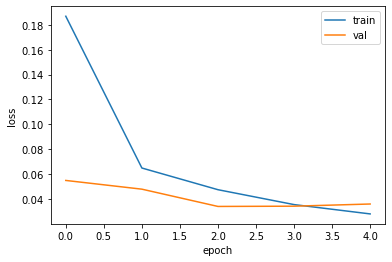

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## model.evaluate()를 사용하여 검증 세트에 대한 성능을 측정하시오

In [55]:
model.evaluate(val_scaled, val_target)

12000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.03398046365358944, 0.98966664]

##검증세트의 두번째 (인덱스 1) 이미지 출력

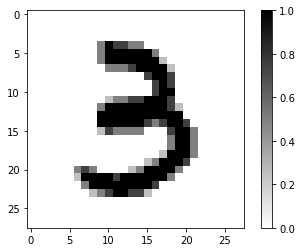

In [56]:
plt.imshow(val_scaled[1].reshape(28,28), cmap='gray_r')
plt.colorbar()
plt.show()

## 검증세트 두번째 (인덱스 1) 샘플의 예측결과를 확인

In [65]:
#predict()메소드를 사용하면 됩니다. 수업자료 참고
preds = model.predict(val_scaled[1:2])
print(preds)

[[4.2374304e-14 1.2862170e-09 1.3161638e-09 1.0000000e+00 6.4664006e-14
  1.1266989e-08 2.0747284e-15 2.5214184e-09 3.1359375e-09 8.5465972e-09]]


## 위 예측결과를 그래프로 출력 후 확인

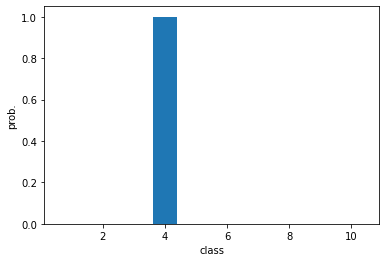

In [58]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [59]:
classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five',
           'Six', 'Seven', 'Eight', 'Nine']

In [60]:
import numpy as np
print(classes[np.argmax(preds)])

Three


##테스트 세트에 대한 성능을 평가해보자 (evaluate() 사용)

In [63]:
#테스트 데이터도 정규화가 필요합니다.
#성능평가시 evaluate()를 사용합니다.
test_scaled = test_input.reshape(-1,28,28,1) / 255.0
model.evaluate(test_scaled, test_target)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.029506471549070556, 0.9904]